# Preliminary Experiment for _AKU_

Bernhard Bermeitinger, bernhard.bermeitinger@uni-passau.de

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

print("Tensorflow:", tf.__version__)
print("Keras:", keras.__version__)

Tensorflow: 1.13.0-rc0
Keras: 2.2.4-tf


In [2]:
import os
import math
from glob import glob
import random
import re
from collections import Counter
import shutil

import subprocess

In [3]:
import cv2
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [70]:
LABEL = 'moe'

from_env = os.getenv('LABEL')
if from_env is not None:
    LABEL = from_env

if LABEL not in ['gar', 'moe']:
    print("wrong label: ", LABEL)

In [71]:
NUM_GPUS = int(str(subprocess.check_output(["nvidia-smi", "-L"])).count('UUID'))

if NUM_GPUS < 1:
    print("NO GPU FOUND, WILL USE CPU")
    NUM_GPUS = 1

else:
    print("Using {} GPUs".format(NUM_GPUS))

Using 1 GPUs


In [72]:
INDIR = os.path.join("/data", "AKU")
OUTDIR = os.path.join("/output")

# Data Reading

In [73]:
df = pd.read_csv(os.path.join(INDIR, 'komplett', 'data.csv'))
df.head(5)

image gar_label moe_label
0  /data/AKU/komplett/converted/GArG19_Moe196_D_A...   gar_g19   moe_196
1  /data/AKU/komplett/converted/Gar0_192B_HT_pEbe...     gar_0       NaN
2  /data/AKU/komplett/converted/Gar0_Moe125B_HT_p...     gar_0  moe_125b
3  /data/AKU/komplett/converted/Gar0_Moe125B_HT_p...     gar_0  moe_125b
4  /data/AKU/komplett/converted/Gar0_Moe125B_HT_p...     gar_0  moe_125b

In [74]:
other_columns = list(df.columns)
other_columns.remove('image')
other_columns.remove("{}_label".format(LABEL))

In [75]:
df = df.dropna(subset=["{}_label".format(LABEL)])
df = df.drop(columns=other_columns)
df = df.rename(columns={"{}_label".format(LABEL): 'label'})

In [76]:
label_counter = Counter(df.label)

MIN_APPEARANCE = 25

allowed_labels = [label for label, count in label_counter.most_common() if count >= MIN_APPEARANCE]

df = df[df.label.isin(allowed_labels)]

NUM_CLASSES = len(df.label.unique())
print("NUM_CLASSES:", NUM_CLASSES)

NUM_CLASSES: 58


## Split into train/test

In [77]:
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

for class_name, group in df.groupby(['label']):
    cls_train, cls_test = train_test_split(group, test_size=0.2)

    train_df = pd.concat([train_df, cls_train], sort=False)
    test_df = pd.concat([test_df, cls_test], sort=False)

In [78]:
train_df.to_csv(os.path.join(OUTDIR, "train_df_{}.csv".format(LABEL)))
test_df.to_csv(os.path.join(OUTDIR, "test_df_{}.csv".format(LABEL)))

In [79]:
LBL_BIN = LabelBinarizer()
LBL_BIN.fit(sorted(df.label.unique()))
joblib.dump(LBL_BIN, os.path.join(OUTDIR, 'LBL-BIN_{}.pkl'.format(LABEL)), compress=True)

['/output/LBL-BIN_moe.pkl']

In [80]:
def load_image(image_path, size, channels=1, augment=True):
    if channels == 3:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif channels == 1:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    
    if augment:
        rows, cols = img.shape[:2]
        # random rotation
        M = cv2.getRotationMatrix2D((cols/2, rows/2), np.random.randint(-7, 7), 1)
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        # random shear
        M = np.float32([
            [1, 0, np.random.uniform(-cols * 0.07, cols * 0.07)],
            [0, 1, np.random.uniform(-rows * 0.07, rows * 0.07)]])
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        # random zoom
        M = np.float32([
            [1+np.random.uniform(0.0, 0.07), 0, 0],
            [0, 1+np.random.uniform(0.0, 0.07), 0]
        ])
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)
    
    img = img.reshape(*size, channels)
    img = img.astype('float32')
    
    img /= 255.0
    
    return img

image    /data/AKU/komplett/converted/GarM17_Moe282_HT_...
label                                              moe_282
Name: 3583, dtype: object


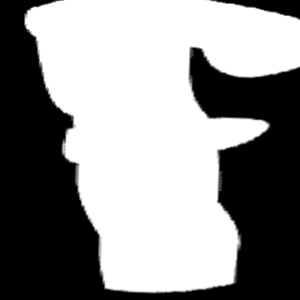

In [81]:
ex = df.sample(1).iloc[0]
print(ex)
img = load_image(ex.image, (300, 300), 1, augment=True)
Image.fromarray((np.array(img[:, :, 0]) * 255).astype(np.uint8))

In [82]:
len(LBL_BIN.classes_)

58

In [83]:
class MnistSequence(keras.utils.Sequence):
    def __init__(self, image_size=(299, 299), channels=3, batch_size=64, mode='train'):
        self.batch_size = batch_size
        self.mode = mode
        self.image_size = image_size
        self.channels = channels
        
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        
        self.lbl_bin = LabelBinarizer()
        self.lbl_bin.fit(sorted(set(y_train) & set(y_test)))
        
        if mode == 'train':
            self.images = x_train
            self.labels = y_train
        elif mode == 'test':
            self.images = x_test
            self.labels = y_test
        
        self.indexes = np.arange(len(self.images))
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.indexes))
        if self.mode == 'train':
            np.random.shuffle(self.indexes)

    def get_batch_images(self, idx):
        batch_images = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = np.empty((len(batch_images), *self.image_size, self.channels))
        
        for i, img in enumerate(batch_images):
            images[i] = self._preprocess_image(img, augment=self.mode == 'train')
        return images
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        return self.lbl_bin.transform(batch_labels)
        

    def _preprocess_image(self, img, augment=True):
        img = cv2.resize(img, self.image_size, interpolation=cv2.INTER_AREA)
    
        if augment:
            rows, cols = img.shape[:2]
            # random rotation
            M = cv2.getRotationMatrix2D((cols/2, rows/2), np.random.randint(-7, 7), 1)
            img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

            # random shear
            M = np.float32([
                [1, 0, np.random.uniform(-cols * 0.07, cols * 0.07)],
                [0, 1, np.random.uniform(-rows * 0.07, rows * 0.07)]])
            img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

            # random zoom
            M = np.float32([
                [1+np.random.uniform(0.0, 0.07), 0, 0],
                [0, 1+np.random.uniform(0.0, 0.07), 0]
            ])
            img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        img = img.reshape(*self.image_size, self.channels)
        img = img.astype('float32')

        img /= 255.0
        
        return img

    def __getitem__(self, idx):
        batch_x = self.get_batch_images(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [84]:
class AKUSequence(keras.utils.Sequence):
    
    def __init__(self, df, image_size=(299, 299), channels=3, batch_size=64, mode='train'):
        self.image_size = image_size
        self.channels = channels
        
        self.batch_size = batch_size
        if mode not in ['train', 'test']:
            raise ValueError("mode must be 'train' or 'test'")
        self.mode = mode
        
        self.images = df.image
        self.labels = df.label
        
        self.indexes = range(len(self.images))
    
    def __len__(self):
        return int(np.ceil(len(self.indexes) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = range(len(self.images))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))
            
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        return LBL_BIN.transform(batch_labels)
    
    def get_batch_images(self, idx):
        batch_images = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = np.empty((len(batch_images), *self.image_size, self.channels))
        for i, img in enumerate(batch_images):
            images[i] = load_image(
                img,
                size=self.image_size, channels=self.channels,
                augment=self.mode == 'train'
            )
        
        return images
    
    def __getitem__(self, idx):
        batch_x = self.get_batch_images(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [85]:
def print_report(y_true, y_pred):
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))

create model

In [86]:
from tensorflow.keras import layers, metrics, losses, optimizers, callbacks
from tensorflow.keras.models import Model

In [87]:
def build_base_model(image_size, num_channels):
    inputs = layers.Input(shape=(*image_size, num_channels), name='input')

    # input conv
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1_1')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', name='conv_1_2')(x)
    x = layers.MaxPool2D((2, 2), name='pool_1')(x)
    x = layers.Dropout(0.25, name='dropout_1')(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2_1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', name='conv_2_2')(x)
    x = layers.MaxPool2D((2, 2), name='pool_2')(x)
    x = layers.Dropout(0.25, name='dropout_2')(x)

    x = layers.Flatten(name='flatten_1')(x)

    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.Dense(256, activation='relu', name='dense_2')(x)
    x = layers.Dropout(0.5, name='dropout_3')(x)
    
    return keras.models.Model(inputs=inputs, outputs=x)

In [88]:
BATCH_SIZE = 256
IMAGE_SIZE = (128, 128)
NUM_CHANNELS = 1
NUM_CLASSES = len(LBL_BIN.classes_)

mnist_train = MnistSequence(IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE * 4, mode='train')
mnist_test = MnistSequence(IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE * 4, mode='test')

aku_train = AKUSequence(train_df, IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE, mode='train')
aku_test = AKUSequence(test_df, IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE, mode='test')

In [89]:
mnist_class_weight = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=mnist_train.lbl_bin.classes_,
    y=mnist_train.labels
)

aku_class_weight = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=train_df.label.unique(),
    y=train_df.label
)

In [90]:
base_model = build_base_model(IMAGE_SIZE, NUM_CHANNELS)

In [91]:
mnist_output = layers.Dense(len(mnist_train.lbl_bin.classes_), activation='softmax', name='output')(base_model.output)

mnist_model = keras.models.Model(inputs=base_model.input, outputs=mnist_output)

mnist_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.categorical_accuracy, keras.metrics.top_k_categorical_accuracy]
)

h_1 = mnist_model.fit_generator(
    generator=mnist_train,
    validation_data=mnist_test,
    epochs=50,
    use_multiprocessing=True,
    workers=8,
    class_weight=mnist_class_weight,
    callbacks=[keras.callbacks.EarlyStopping(patience=25)]
)

Epoch 1/50
58/58 [==============================] - 46s 786ms/step - loss: 0.6517 - categorical_accuracy: 0.7869 - top_k_categorical_accuracy: 0.9625 - val_loss: 0.1090 - val_categorical_accuracy: 0.9664 - val_top_k_categorical_accuracy: 0.9991
Epoch 2/50
58/58 [==============================] - 39s 669ms/step - loss: 0.1594 - categorical_accuracy: 0.9514 - top_k_categorical_accuracy: 0.9977 - val_loss: 0.0555 - val_categorical_accuracy: 0.9834 - val_top_k_categorical_accuracy: 0.9997
Epoch 3/50
58/58 [==============================] - 39s 670ms/step - loss: 0.1138 - categorical_accuracy: 0.9666 - top_k_categorical_accuracy: 0.9987 - val_loss: 0.0435 - val_categorical_accuracy: 0.9868 - val_top_k_categorical_accuracy: 0.9998
Epoch 4/50
58/58 [==============================] - 38s 664ms/step - loss: 0.0891 - categorical_accuracy: 0.9735 - top_k_categorical_accuracy: 0.9990 - val_loss: 0.0350 - val_categorical_accuracy: 0.9885 - val_top_k_categorical_accuracy: 0.9999
Epoch 5/50
58/58 [==

In [92]:
aku_output = layers.Dense(len(LBL_BIN.classes_), activation='softmax', name='output')(base_model.output)

aku_model = Model(inputs=base_model.input, outputs=aku_output)

In [93]:
aku_model.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
)

h_2 = aku_model.fit_generator(
    generator=aku_train,
    validation_data=aku_test,
    epochs=1000,
    use_multiprocessing=True,
    workers=4,
    class_weight=aku_class_weight,
    callbacks=[callbacks.EarlyStopping(patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 7s 663ms/step - loss: 7.8031 - categorical_accuracy: 0.0155 - top_k_categorical_accuracy: 0.0742 - val_loss: 5.0526 - val_categorical_accuracy: 0.0119 - val_top_k_categorical_accuracy: 0.0992
Epoch 2/1000
11/11 [==============================] - 3s 271ms/step - loss: 5.6881 - categorical_accuracy: 0.0159 - top_k_categorical_accuracy: 0.0774 - val_loss: 4.4755 - val_categorical_accuracy: 0.0119 - val_top_k_categorical_accuracy: 0.0963
Epoch 3/1000
11/11 [==============================] - 3s 265ms/step - loss: 4.9129 - categorical_accuracy: 0.0197 - top_k_categorical_accuracy: 0.0859 - val_loss: 4.2533 - val_categorical_accuracy: 0.0104 - val_top_k_categorical_accuracy: 0.1096
Epoch 4/1000
11/11 [==============================] - 3s 267ms/step - loss: 4.5453 - categorical_accuracy: 0.0217 - top_k_categorical_accuracy: 0.0862 - val_loss: 4.1386 - val_categorical_accuracy: 0.0119 - val_top_k_categorical_accuracy: 0.1119
Epoch 5/1000
11/

In [96]:
print("On MNIST")
print("\t VAL_ACC: {:.4f}".format(h_1.history['val_categorical_accuracy'][-1]))
print("\t VAL_TOP_5_ACC: {:.4f}".format(h_1.history['val_top_k_categorical_accuracy'][-1]))

print("On AKU")
print("\t VAL_ACC: {:.4f}".format(h_2.history['val_categorical_accuracy'][-1]))
print("\t VAL_TOP_5_ACC: {:.4f}".format(h_2.history['val_top_k_categorical_accuracy'][-1]))

On MNIST
	 VAL_ACC: 0.9948
	 VAL_TOP_5_ACC: 1.0000
On AKU
	 VAL_ACC: 0.7701
	 VAL_TOP_5_ACC: 0.9242


In [97]:
aku_model.save(os.path.join(OUTDIR, "aku_{}.model".format(LABEL)))
aku_model.save_weights(os.path.join(OUTDIR, "aku_{}.weights".format(LABEL)))
with open(os.path.join(OUTDIR, "aku_{}.json".format(LABEL)), 'w') as fo:
    fo.write(aku_model.to_json())
with open(os.path.join(OUTDIR, "aku_{}.yml".format(LABEL)), 'w') as fo:
    fo.write(aku_model.to_yaml())